In [2]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from netCDF4 import Dataset

from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
import mpl_toolkits

sys.path.append('/noc/users/am8e13/PyNGL-1.4.0/lib/python2.7/site-packages/PyNGL/')
import Ngl
sys.path.append('/noc/users/am8e13/Python/')
import komod
sys.path.append('/noc/users/am8e13/Python/PyNIO-1.4.0/')
import Nio

from python_functions import *
import cmocean
import random
import calendar

from IPython.html.widgets import interact, interactive
from IPython.display import clear_output, display, HTML

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [224]:
class Woa:
    def __init__(self):
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results36km/grid.nc",'r')
        bathy = file2read.variables['HFacC']
        self.bathy = bathy[:]*1
        self.res = 36
        Z = file2read.variables['Z']
        Z = Z[:]*1
        self.Z = Z
        lat = file2read.variables['YC']
        self.lat = lat[:]*1
        lon = file2read.variables['XC']
        self.lon = lon[:]*1
        file1 = '/scratch/general/am8e13/WOA/WOA05_THETA_210x192x50_arctic'
        self.T = komod.mitbin(file1,xdim=192,ydim=210,zdim=50,datatype='float32')
        self.T = np.squeeze(self.T,axis=0)
        self.T[self.bathy == 0] = np.nan
        file1 = '/scratch/general/am8e13/WOA/WOA05_SALT_210x192x50_arctic'
        self.S = komod.mitbin(file1,xdim=192,ydim=210,zdim=50,datatype='float32')
        self.S = np.squeeze(self.S,axis=0)
        self.S[self.bathy == 0] = np.nan
        self.rho = rho(self.S,self.T)
        self.rhop = rhop(self.S,self.T)
        self.depth = Z
        # calculate jmd 95 density                                                                                                                
        
        # 18 km files                                                                                                                             
        file1 = '/scratch/general/am8e13/WOA/WOA05_THETA_420x384x50_arctic'
        self.T18 = komod.mitbin(file1,xdim=384,ydim=420,zdim=50,datatype='float32')
        self.T18 = np.squeeze(self.T18,axis=0)
        file1 = '/scratch/general/am8e13/WOA/WOA05_SALT_420x384x50_arctic'
        self.S18 = komod.mitbin(file1,xdim=384,ydim=420,zdim=50,datatype='float32')
        self.S18 = np.squeeze(self.S18,axis=0)

        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results18km/grid.nc",'r')
        bathy = file2read.variables['HFacC']
        self.bathy = bathy[:]*1
        self.T18[self.bathy == 0] = np.nan
        self.S18[self.bathy == 0] = np.nan

        self.rho18 = rho(self.S18,self.T18)
        self.rhop18 = rhop(self.S18,self.T18)

        # 9 km files                                                                                                                              
        file1 = '/scratch/general/am8e13/WOA/WOA05_THETA_840x768x50_arctic'
        self.T9 = komod.mitbin(file1,xdim=768,ydim=840,zdim=50,datatype='float32')
        self.T9 = np.squeeze(self.T9,axis=0)
        file1 = '/scratch/general/am8e13/WOA/WOA05_SALT_840x768x50_arctic'
        self.S9 = komod.mitbin(file1,xdim=768,ydim=840,zdim=50,datatype='float32')
        self.S9 = np.squeeze(self.S9,axis=0)

        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results9km/grid.nc",'r')
        bathy = file2read.variables['HFacC']
        self.bathy = bathy[:]*1
        self.T9[self.bathy == 0] = np.nan
        self.S9[self.bathy == 0] = np.nan

        self.rho9 = rho(self.S9,self.T9)
        self.rhop9 = rhop(self.S9,self.T9)


        self.rho_jmd = np.zeros_like(self.rho)
        for z in range(len(self.Z)):
            self.rho_jmd[z,:,:] = densjmd95(self.S[z,:,:],self.T[z,:,:],-9.81*self.Z[z]*1025)

        self.title = 'Woa'
        self.dataDyn = {}
        temp_lv = np.nanmean(np.nanmean(self.T,axis=1),axis=1)
        self.dataDyn['theta_lv_mean'] = (np.ones((400,1))*temp_lv)
        temp_lv = np.nanmean(np.nanmean(self.S,axis=1),axis=1)
        self.dataDyn['salt_lv_mean'] = (np.ones((400,1))*temp_lv)
        self.dataDyn['rho_lv_mean'] = rhop(self.dataDyn['salt_lv_mean'],self.dataDyn['theta_lv_mean'])

# Reading the Noaa file
woa = Woa()

This notebook is meant to study the spinup of the various model setup

In [3]:
# Reading the Noaa file
woa = Woa()

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [4]:
# Read ERA data
ERA_36 = RunRead()
ERA_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_sponge_noscaled/results/')
ERA_36.readMonitorData([0,777600])
ERA_36.readMonitorSeaiceData([0,777600])
ERA_36.readDynStData([0,777600,])
ERA_36.readStateData(range(1080-18,1080,1))
ERA_36.baroCalc()
ERA_36.mxldepthread(range(12))
ERA_36.seaiceread(range(12))
ERA_36.fluxCalc()
ERA_36.title('ERA 36km','purple')

Read Monitor
Read Seaice Monitor
Read StDyn data
Data read from /hpcdata/scratch/am8e13/cs_36km_tutorial/run_sponge_noscaled/results/
Read Mxldepth
Read seaice


/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:220: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


In [6]:
CORE_36 = RunRead()
CORE_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_spinup_CORE_runofffixed/results/')
CORE_36.readMonitorData([0,777600,1555200,2332800,3110400,3888000,4665600])
CORE_36.readMonitorSeaiceData([0,777600,1555200,2332800,3110400,3888000,4665600])
CORE_36.readDynStData([0,777600,1555200,2332800,3110400,3888000,4665600])
#CORE_36.readStateData(range(720-12,720,1))
CORE_36.readStateData(range(720-2,720,1))
CORE_36.baroCalc()
CORE_36.mxldepthread(range(12))
CORE_36.seaiceread(range(12))
CORE_36.fluxCalc()
CORE_36.title('CORE 36km','red')

Read Monitor
Read Seaice Monitor
Read StDyn data
Data read from /hpcdata/scratch/am8e13/cs_36km_tutorial/run_spinup_CORE_runofffixed/results/
Read Mxldepth
Read seaice


In [47]:
CORE_18 = RunRead()
CORE_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/run_spinup_CORE/results/')
CORE_18.readMonitorData([0,345600,691200,1036800,1382400,1728000,2073600,2419200,\
                                2764800,3110400,3456000,3801600,4147200,4492800,4838400])
CORE_18.readMonitorSeaiceData([0,345600,691200,1036800,1382400,1728000,2073600,2419200,\
                                2764800,3110400,3456000,3801600,4147200,4492800,4838400])
CORE_18.readDynStData([0,345600,691200,1036800,1382400,1728000,2073600,2419200,\
                                2764800,3110400,3456000,3801600,4147200,4492800,4838400])
#CORE_18.readStateData(range(240-12,240,1))
CORE_18.readStateData(range(240-2,240,1))
CORE_18.baroCalc()
CORE_18.fluxCalc()
CORE_18.mxldepthread(range(12))
CORE_18.seaiceread(range(12))
CORE_18.title('CORE 18km','cyan')

Read Monitor
Read Seaice Monitor
Read StDyn data
Data read from /hpcdata/scratch/am8e13/arctic420x384/run_spinup_CORE/results/
Read Mxldepth
Read seaice


In [44]:
CORE_9 = RunRead()
CORE_9.getPath('/hpcdata/scratch/am8e13/run_template_9km/run_spinup_core/results/')
CORE_9.readMonitorData([0,138240,276480,414720,552960,691200,829440,967680,1105920,\
                               1244160,1382400,1520640,1658880,1797120,1935360])
CORE_9.readMonitorSeaiceData([0,138240,276480,414720,552960,691200,829440,967680,1105920,\
                               1244160,1382400,1520640,1658880,1797120,1935360])
CORE_9.readDynStData([0,138240,276480,414720,552960,691200,829440,967680,1105920,\
                               1244160,1382400,1520640,1658880,1797120,1935360])
#CORE_9.readStateData(range(48-12,48,1))
CORE_9.readStateData(range(48-2,48,1))
CORE_9.baroCalc()
CORE_9.mxldepthread(range(12))
CORE_9.seaiceread(range(12))
CORE_9.fluxCalc()
CORE_9.title('CORE 9km','black')

Read Monitor
Read Seaice Monitor
Read StDyn data
Data read from /hpcdata/scratch/am8e13/run_template_9km/run_spinup_core/results/
Read Mxldepth
Read seaice


negative salinity values! setting to nan


In [12]:
liq10,core2,obs = lit_data();
for var in ['Barents1','Bering','Fram','Davis']:
    print var
    print 'ERA_36',ERA_36.totalFluxes[var]
    print 'COR_36',CORE_36.totalFluxes[var]
    print 'COR_18',CORE_18.totalFluxes[var]
    print 'COR_9 ',CORE_9.totalFluxes[var]
    print 'liq10 ',liq10[var]
    print 'Core2 ',core2[var]
    print 'obsv  ',obs[var]

Barents1
ERA_36 {'Outflow': -1.15, 'Total flow': -0.63, 'Inflow': 0.52}
COR_36 {'Outflow': -3.17, 'Total flow': -0.31, 'Inflow': 2.86}
COR_18 {'Outflow': -3.39, 'Total flow': -0.13, 'Inflow': 3.26}
COR_9  {'Outflow': -4.15, 'Total flow': -1.51, 'Inflow': 2.64}
liq10  {'Outflow': 4.1, 'Total flow': 2.9, 'Inflow': -1.2}
Core2  {'Outflow': [], 'Total flow': 2.53, 'Inflow': []}
obsv   {'Outflow': 4.1, 'Total flow': '2-2.3', 'Inflow': -1.2}
Bering
ERA_36 {'Outflow': -0.03, 'Total flow': 1.23, 'Inflow': 1.25}
COR_36 {'Outflow': -0.01, 'Total flow': 1.4, 'Inflow': 1.41}
COR_18 {'Outflow': -0.0, 'Total flow': 1.36, 'Inflow': 1.36}
COR_9  {'Outflow': -0.0, 'Total flow': 1.35, 'Inflow': 1.35}
liq10  {'Outflow': 0.0, 'Total flow': 1.3, 'Inflow': 1.3}
Core2  {'Outflow': [], 'Total flow': 0.99, 'Inflow': []}
obsv   {'Outflow': [], 'Total flow': '0.8+/-0.2', 'Inflow': []}
Fram
ERA_36 {'Outflow': -2.47, 'Total flow': -0.59, 'Inflow': 1.88}
COR_36 {'Outflow': -5.81, 'Total flow': 1.22, 'Inflow': 7.04}

In [225]:
comp_all = {0 : woa ,1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9}

In [34]:
comp_36 = {0 : woa ,1 : ERA_36, 2 : CORE_36}

In [35]:
comp_core = {2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9}

In [137]:
def comp_plot(data, reg,npoints=15):
    import matplotlib as mpl
    # This function plots time evolution of temperature/salinity on a transect.                                                    
    # Transect are: Fram Strait, Bering Strait ...                  
                                                                                                               
    npl = len(data)                                                                                                                  
    regions = {"barents" : [77,-20,79,10] , "fram" : [80,-13,79,10] , "bering" : [64,-169,67,-168] , \
               "davis" : [66,-61,66,-53] , "arctic1" : [83,-28,74,136] , "arctic2" : [71,-139,75,53], \
               "arctic3" : [78,-115,76,111] , "arctic4" : [60,180,60,0] }
    region = regions[reg]
    
    lat1 = region[0] ; lon1 = region[1] ; lat2 = region[2] ; lon2 = region[3] ;
    fig, axes = plt.subplots(3,npl,sharex='col', sharey='row')
    ind = 0

    t_min = -2 ; t_max = 8 ; tempbounds = np.linspace(t_min,t_max,15) ; tempbounds1 = np.linspace(t_min,t_max,5)
    s_min = 30 ; s_max = 35.5 ; saltbounds = np.linspace(s_min,s_max,15) ; saltbounds1 = np.linspace(s_min,s_max,5)
    r_min = 26 ; r_max = 29 ; rhobounds = np.linspace(r_min,r_max,15) ; rhobounds1 = np.linspace(r_min,r_max,5)

    for run in data:
        # plot temperature                                                                                                           
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].T , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        Z,z2 = lastnan(data_prof,data[run].depth)
        if ind == 0:
            imT = axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.temperature)
        else:
            axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.temperature)
                                                                           
        axes.flat[ind].set_title("Temp - "+data[run].title)
        axes.flat[ind].title.set_fontsize('14')
        if ind == 0:
            axes.flat[ind].set_ylabel(r"m")

        # plot salinity                                                                                                              
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].S , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        if ind == 0:
            imS = axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.salt)
        else:
            axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.salt)
        axes.flat[ind+npl].set_title("Sal - "+data[run].title)
        axes.flat[ind+npl].title.set_fontsize('14')
        if ind == 0:
            axes.flat[ind+npl].set_ylabel(r"$m$")

        # plot density                                                                                                               
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].rhop - 1000 , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        if ind == 0:
            imrho = axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.rho)
        else:
            axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.rho)                                                                                          
        axes.flat[ind+npl*2].set_title("Dens - "+data[run].title)
        axes.flat[ind+npl*2].title.set_fontsize('14')
        if ind == 0:
            axes.flat[ind+npl*2].set_ylabel(r'$m$')
        axes.flat[ind+npl*2].set_xlabel(r'$km$')

        # this is to plot ticks   
        ax = axes.flat[ind+npl].get_xaxis()
        ax.set_ticks(km_ticks[reg])                                                                                                            
        ind = ind + 1

    cbar_ax = fig.add_axes([2.15, 2.2, 0.045, 0.7])
    cbar = plt.colorbar(imT, cax=cbar_ax,ticks=[-1,0,1,2,3,4,5,6,7])
    cbar.ax.set_ylabel(r'$^{\circ}C$')

    cbar_ax2 = fig.add_axes([2.15, 1.2, 0.045, 0.7])
    cbar2 = plt.colorbar(imS, cax=cbar_ax2,ticks=[30,31,32,33,34,35])
    cbar2.ax.set_ylabel(r'$psu$')

    cbar_ax3 = fig.add_axes([2.15, 0.2, 0.045, 0.7])
    cbar3 = plt.colorbar(imrho, cax=cbar_ax3,ticks=[26.0,26.5,27.0,27.5,28.0,28.5,29])
    cbar3.ax.set_ylabel(r'$kg/m^3$')

    fig.subplots_adjust(right=2.1,top=3.)

In [181]:
km_ticks = {"bering" : [ 0 , 100 , 200 , 300] , "fram" : [0 , 150 , 300 , 450] , "barents" : [ 0 , 200 , 400 , 600] ,
           "davis" : [0 , 100 , 200 , 300] , "arctic1" : [0 , 750 , 1500 , 2250], "arctic2" : [0,1000,2000,3000] ,
            "arctic3" : [0 , 750 , 1500 , 2250] , "arctic4" : [0 , 2000 , 4000 , 6000]}

Bering Strait

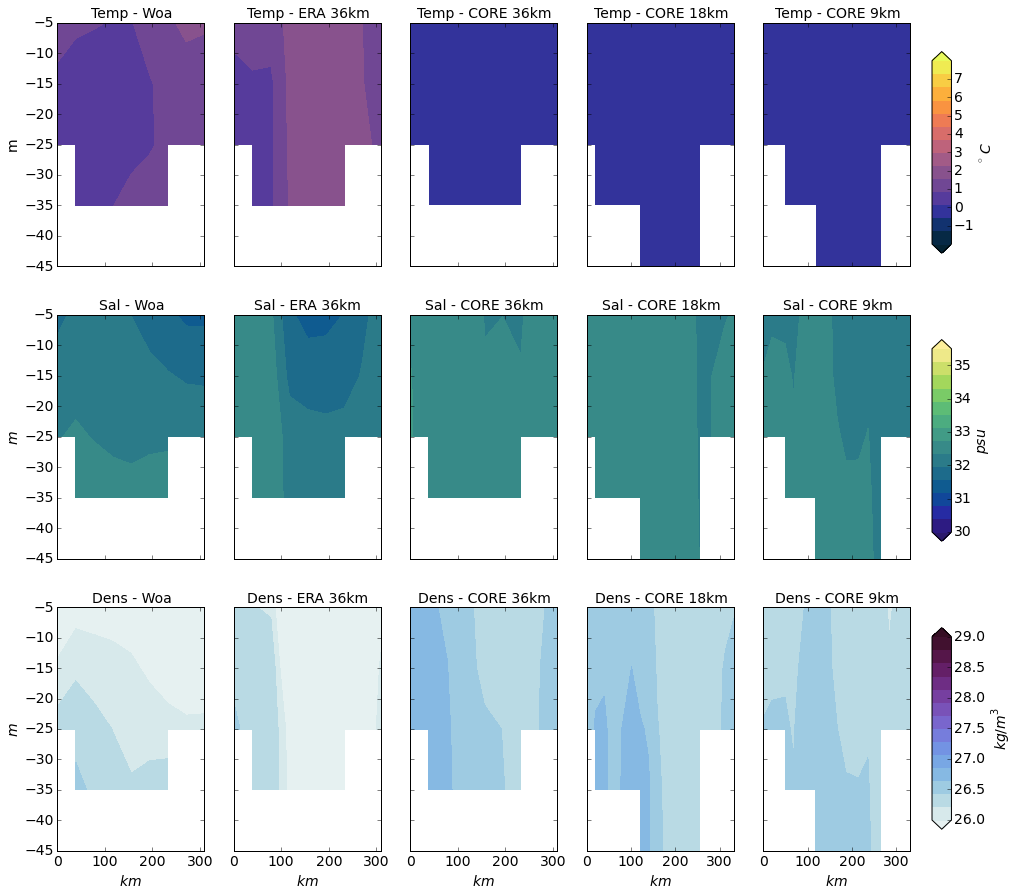

In [226]:
comp_plot(comp_all,"bering")

Fram Strait

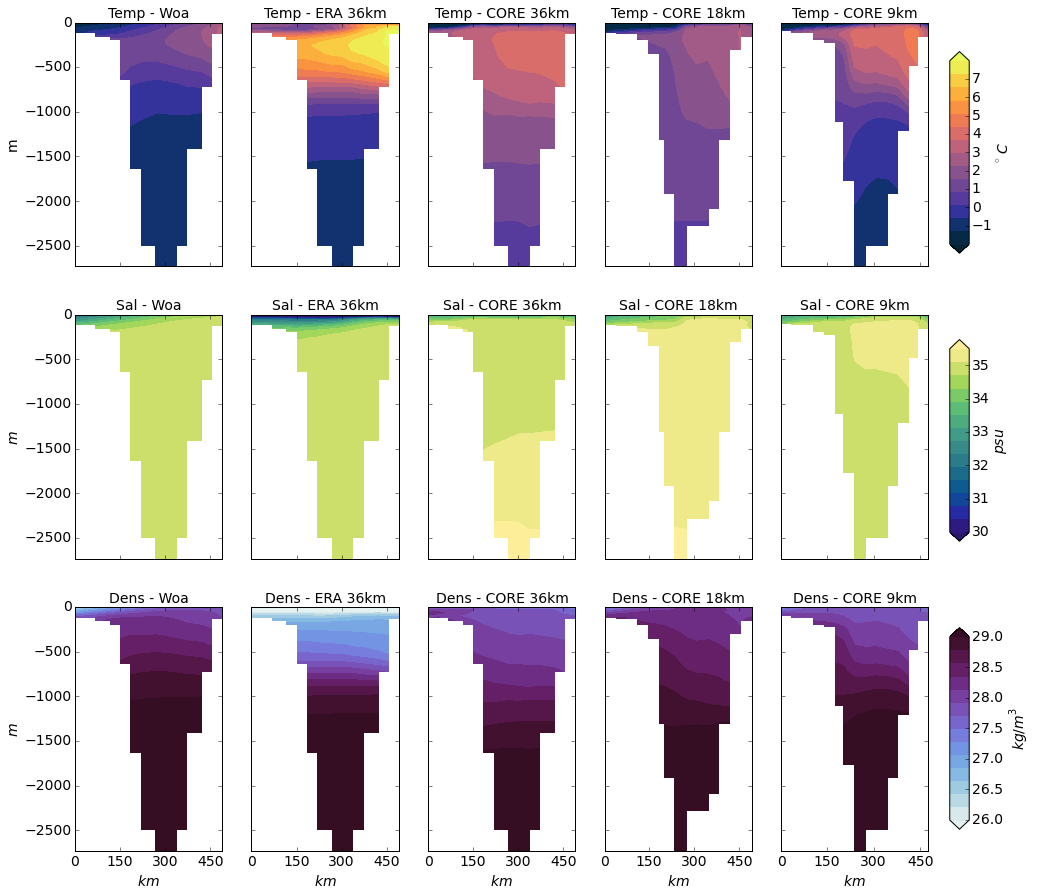

In [227]:
comp_plot(comp_all,'fram')

Barents Strait

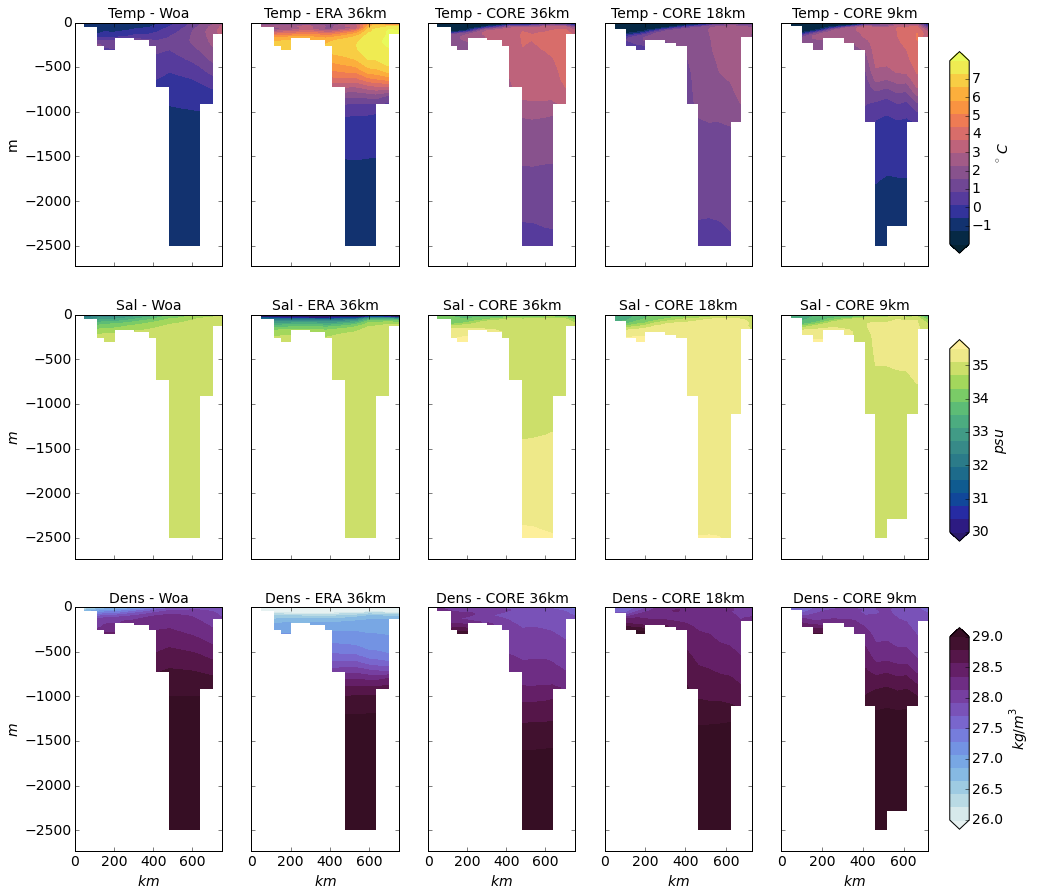

In [228]:
comp_plot(comp_all,"barents")

Davis Strait

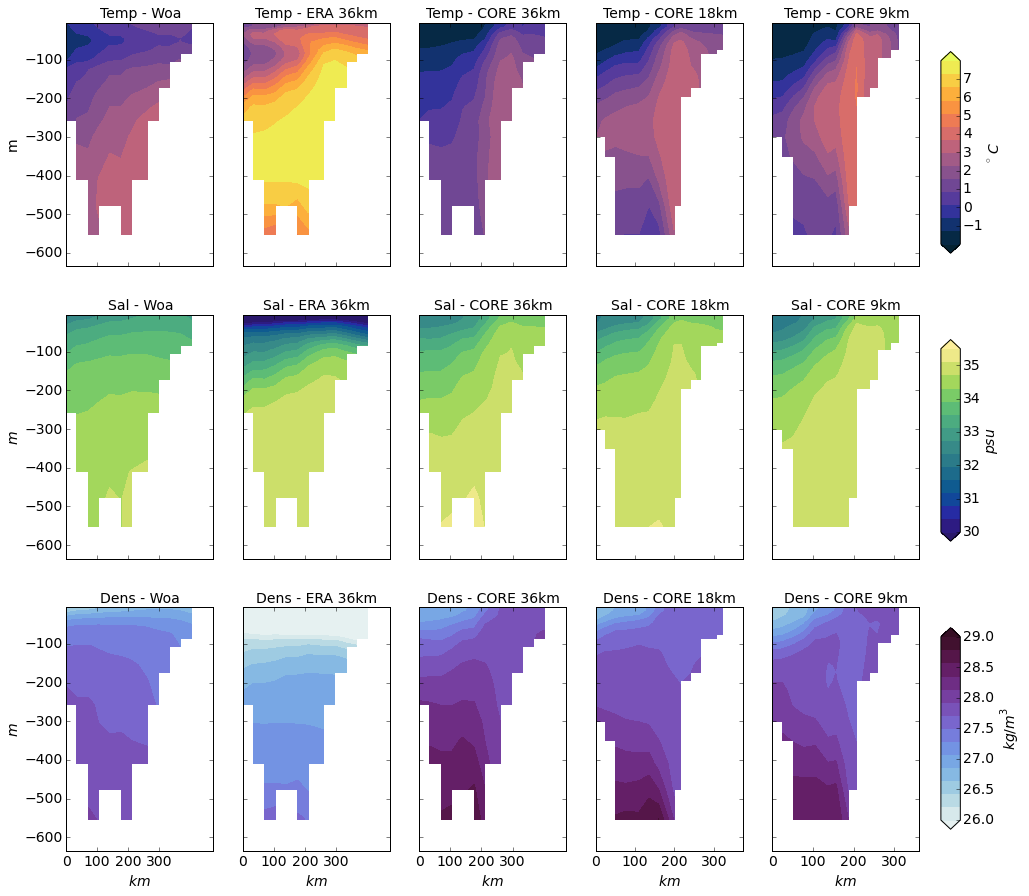

In [229]:
comp_plot(comp_all,"davis")

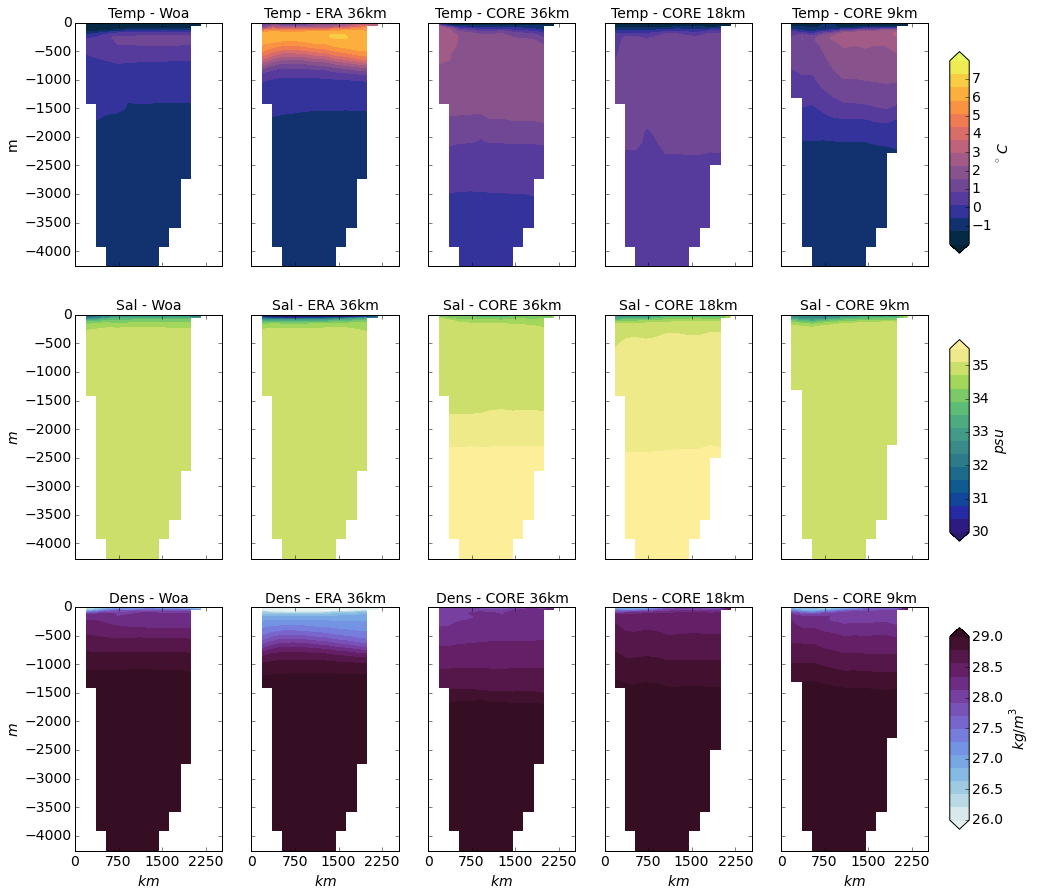

In [230]:
comp_plot(comp_all,"arctic1")

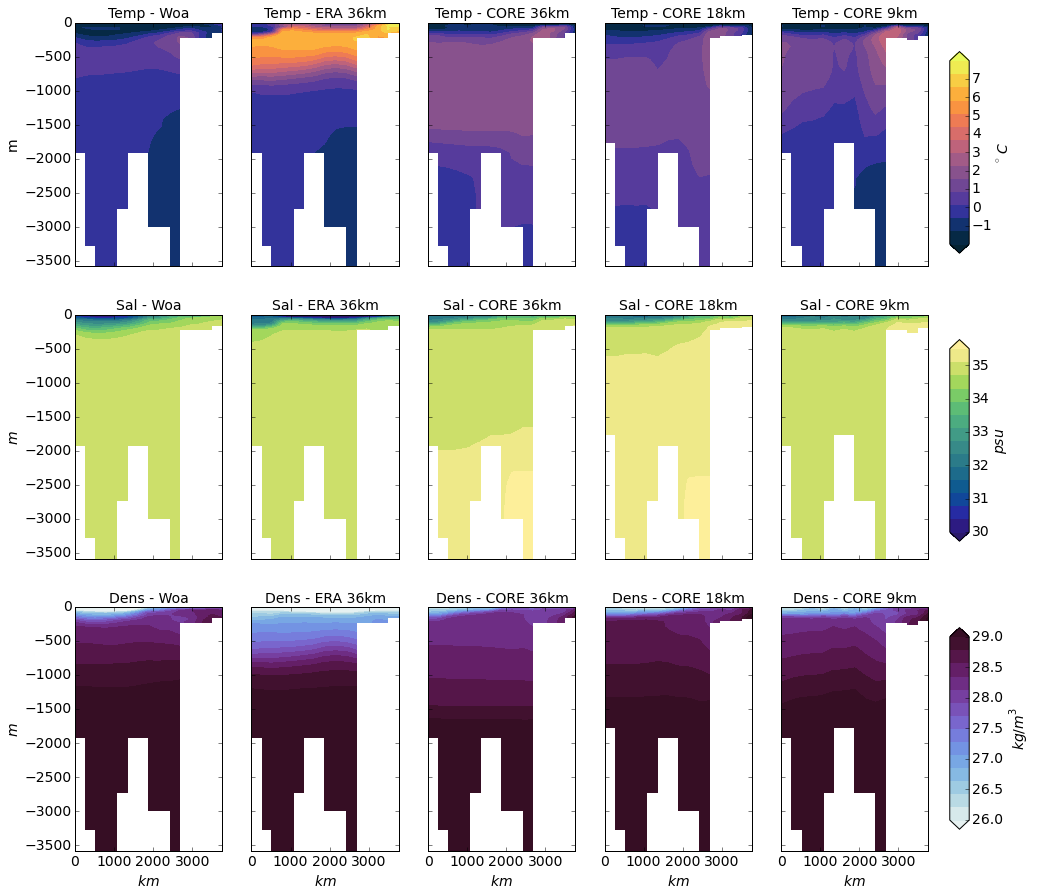

In [231]:
comp_plot(comp_all,"arctic2")

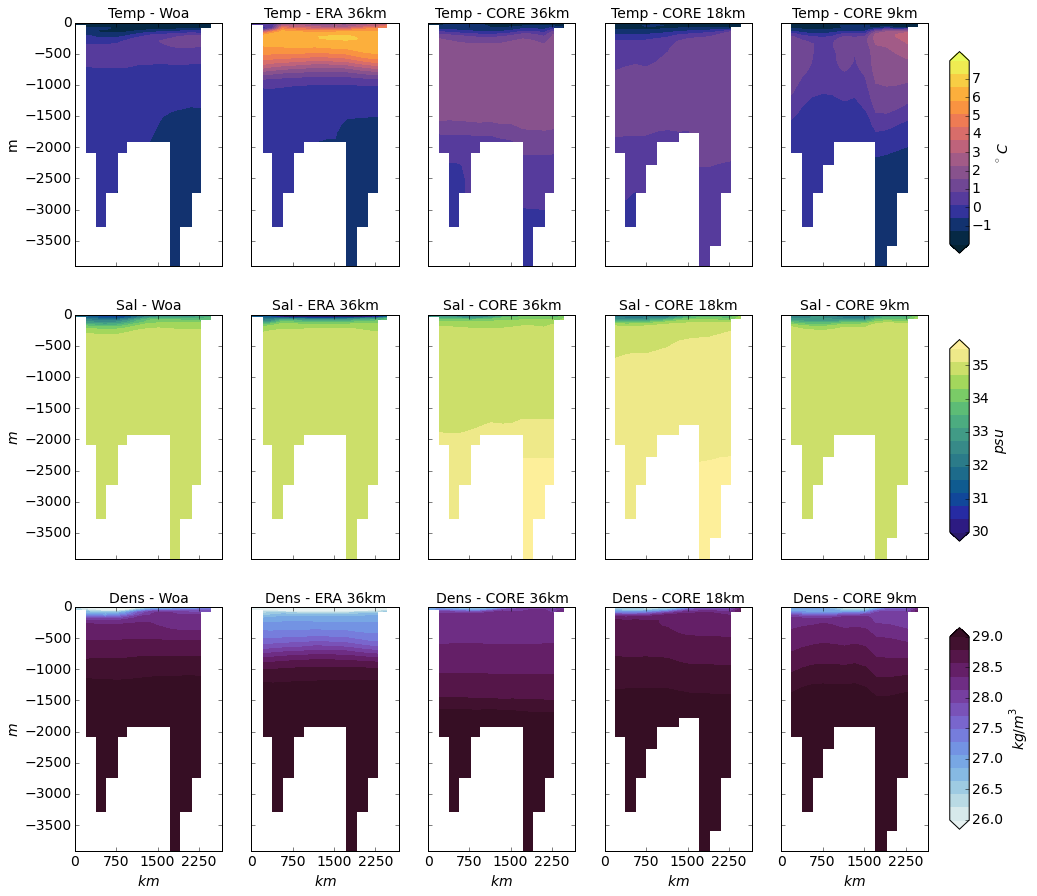

In [232]:
comp_plot(comp_all,"arctic3")

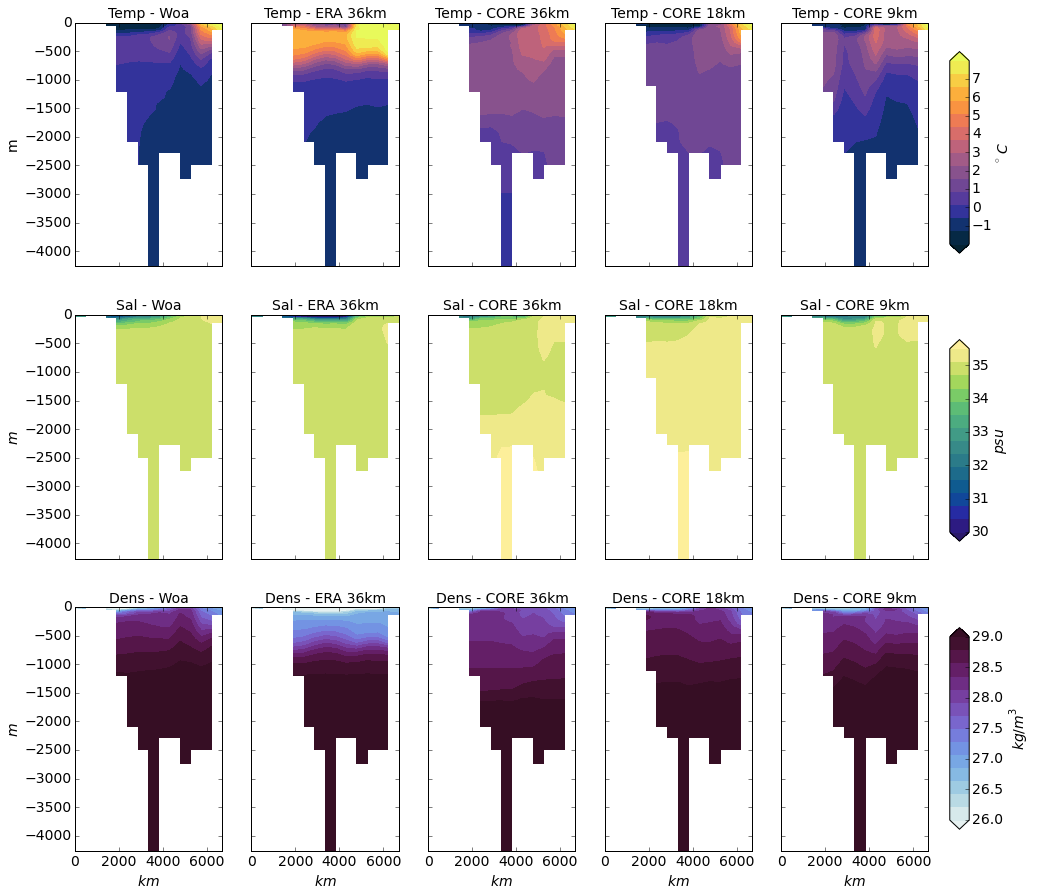

In [233]:
comp_plot(comp_all,"arctic4")

In [196]:
def comp_diff_plot(data,diff, reg,npoints=15):
    import matplotlib as mpl
    # This function plots time evolution of temperature/salinity on a transect. 
    # Transect are: Fram Strait, Bering Strait ...                                  
    
    npl = len(data)
    regions = {"barents" : [77,-20,79,10] , "fram" : [80,-13,79,10] , "bering" : [64,-169,67,-168] , \
               "davis" : [66,-61,66,-53] , "arctic1" : [83,-28,74,136] , "arctic2" : [71,-139,75,53], \
               "arctic3" : [78,-115,76,111] , "arctic4" : [60,180,60,0] }
    region = regions[reg]

    lat1 = region[0]
    lon1 = region[1]
    lat2 = region[2]
    lon2 = region[3]
    fig, axes = plt.subplots(3,npl,sharex='col', sharey='row')
    ind = 0

    t_min = -3 ; t_max = 3 ; tempbounds = np.linspace(t_min,t_max,15) ; tempbounds1 = np.linspace(t_min,t_max,5)
    s_min = -2 ; s_max = 2 ; saltbounds = np.linspace(s_min,s_max,15) ; saltbounds1 = np.linspace(s_min,s_max,5)
    r_min = -1 ; r_max = 1 ; rhobounds = np.linspace(r_min,r_max,15) ; rhobounds1 = np.linspace(r_min,r_max,5)

    for run in data:
        # plot temperature   
        if data[run].res == 36:
            diffT = np.array(diff.T)
            diffS = np.array(diff.S)
            diffrhop = np.array(diff.rhop)
        elif data[run].res == 18:
            diffT = np.array(diff.T18)
            diffS = np.array(diff.S18)
            diffrhop = np.array(diff.rhop18) 
        elif data[run].res == 9:
            diffT = np.array(diff.T9)
            diffS = np.array(diff.S9)
            diffrhop = np.array(diff.rhop9) 
        
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].T - diffT , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        Z,z2 = lastnan(data_prof,data[run].depth)
        if ind == 0:
            imT = axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.freesurface)
        else:
            #print x_kilometers.shape,Z.shape,data_prof[0:z2,:].shape,run
            axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.freesurface)
        #axes.flat[ind].contour(x_kilometers,Z,data_prof[0:z2,:],colors='k',levels = tempbounds1,\                                    
        #            extend = 'both')                                                                                                 
        axes.flat[ind].set_title("T "+data[run].title)
        axes.flat[ind].title.set_fontsize('14')
        if ind == 0:
            axes.flat[ind].set_ylabel('m')

        # plot salinity                                                                                                               
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].S - diffS, lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        
        if ind == 0:
            imS = axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.freesurface)
        else:
            axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.freesurface)
        #axes.flat[ind+npl].contour(x_kilometers,Z,data_prof[0:z2,:],colors='k',levels = saltbounds1,\                                
        #            extend = 'both')                                                                                                 
        axes.flat[ind+npl].set_title("S "+data[run].title)
        axes.flat[ind+npl].title.set_fontsize('14')
        if ind == 0:
            axes.flat[ind+npl].set_ylabel('m')

        # plot density                                                                                                                
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].rhop - diffrhop , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        if ind == 0:
            imrho = axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.freesurface )
        else:
            axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.freesurface)                                                                                        
        axes.flat[ind+npl*2].set_title("rho "+data[run].title)
        axes.flat[ind+npl*2].title.set_fontsize('14')
        if ind == 0:
            axes.flat[ind+npl*2].set_ylabel('m')
        axes.flat[ind+npl*2].set_xlabel('km')  
        # this is to plot ticks   
        ax = axes.flat[ind+npl].get_xaxis()
        ax.set_ticks(km_ticks[reg])                                                                                                                   
        ind = ind + 1

    cbar_ax = fig.add_axes([2.15, 2.2, 0.045, 0.7])
    cbar = plt.colorbar(imT, cax=cbar_ax,ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    cbar.ax.set_ylabel('C')

    cbar_ax2 = fig.add_axes([2.15, 1.2, 0.045, 0.7])
    cbar2 = plt.colorbar(imS, cax=cbar_ax2,ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    cbar2.ax.set_ylabel('psu')

    cbar_ax3 = fig.add_axes([2.15, 0.2, 0.045, 0.7])
    cbar3 = plt.colorbar(imrho, cax=cbar_ax3,ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    cbar3.ax.set_ylabel('kg/m^3')

    fig.subplots_adjust(right=2.1,top=3.)



In [234]:
comp_diff = {1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9}

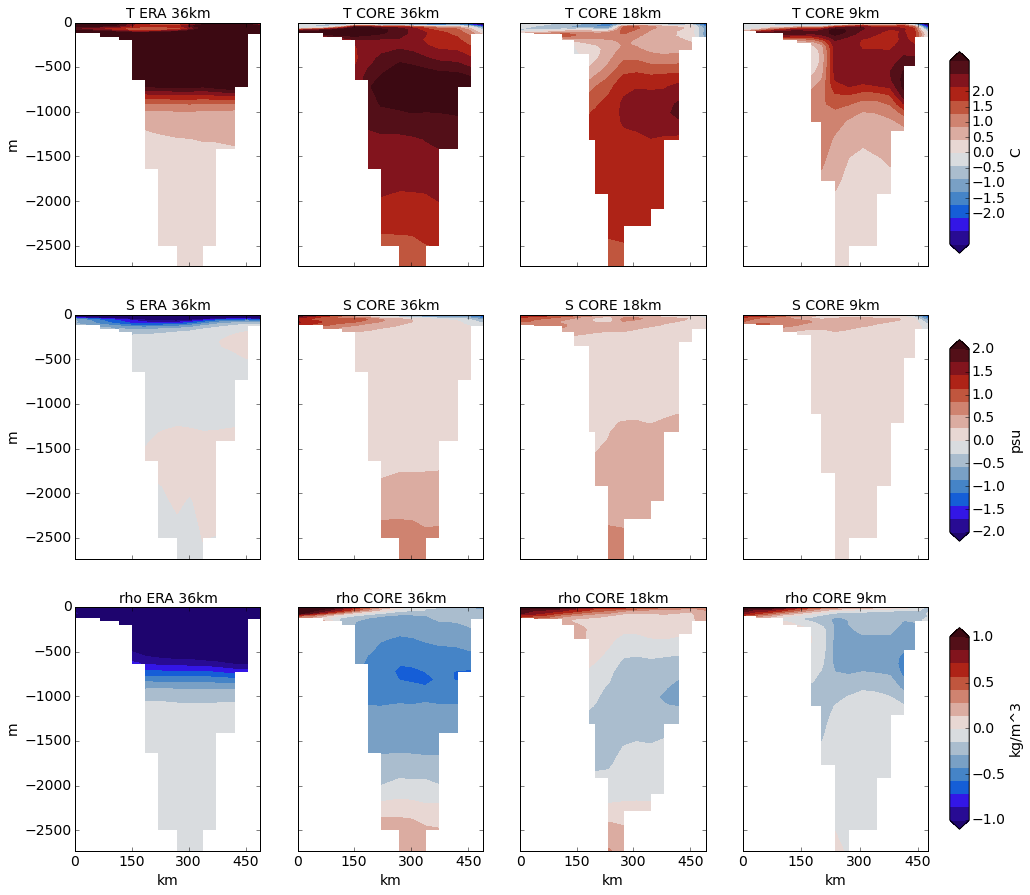

In [235]:
comp_diff_plot(comp_diff,woa,'fram')

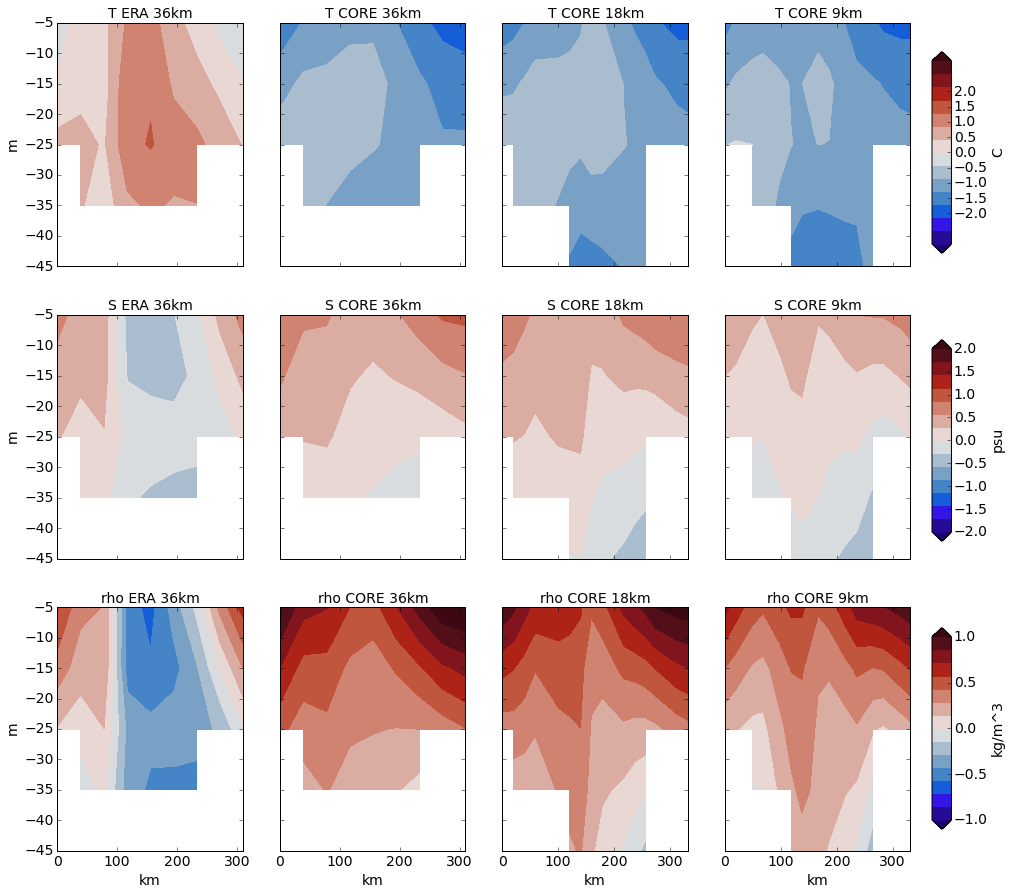

In [236]:
comp_diff_plot(comp_diff,woa,'bering')

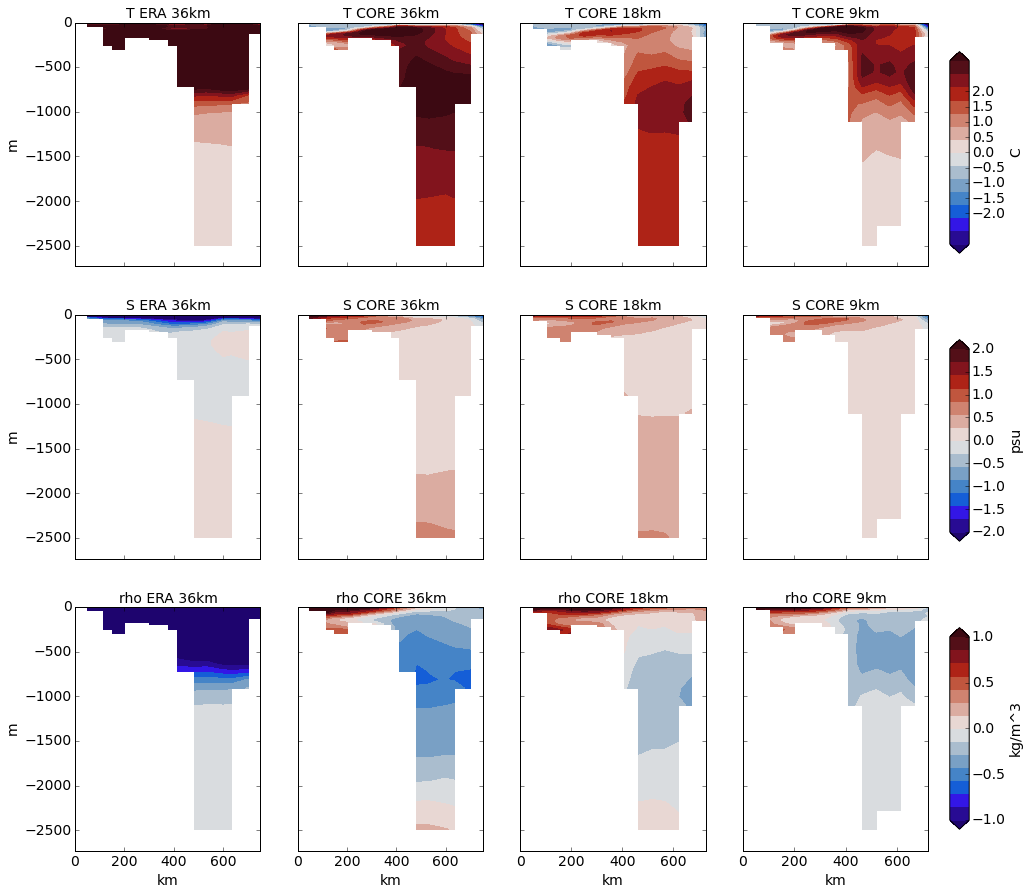

In [237]:
comp_diff_plot(comp_diff,woa,'barents')

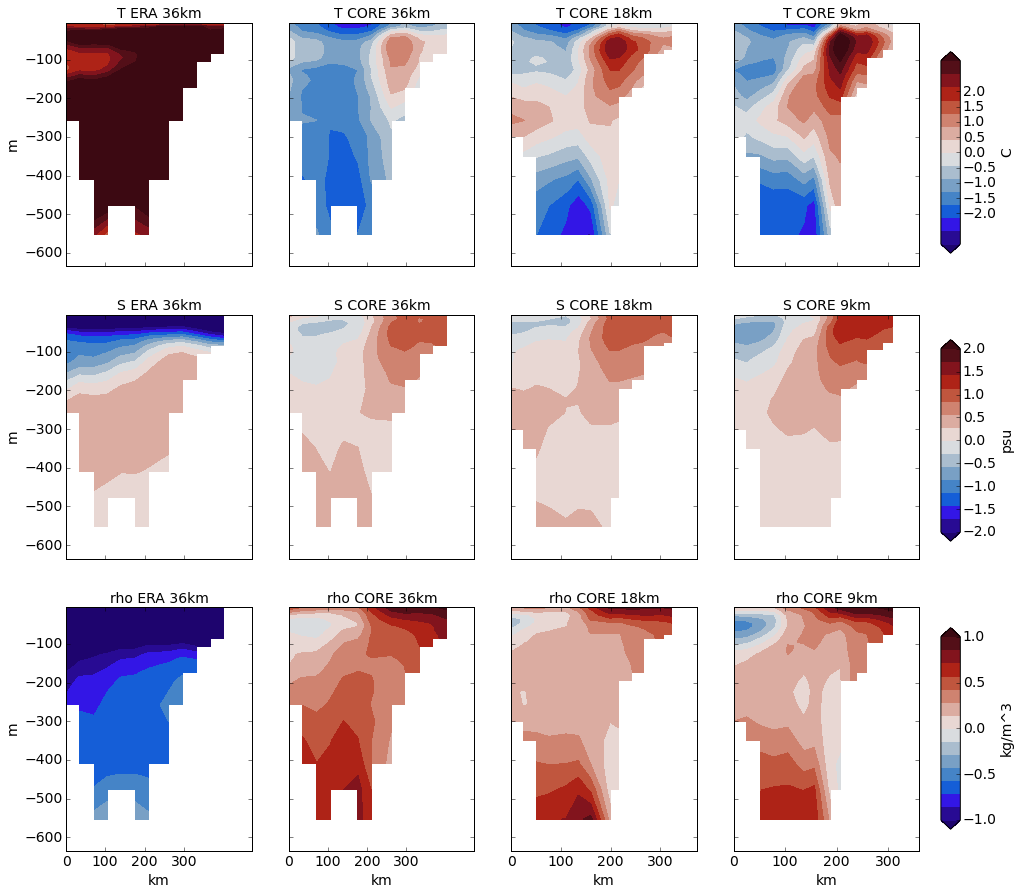

In [238]:
comp_diff_plot(comp_diff,woa,'davis')

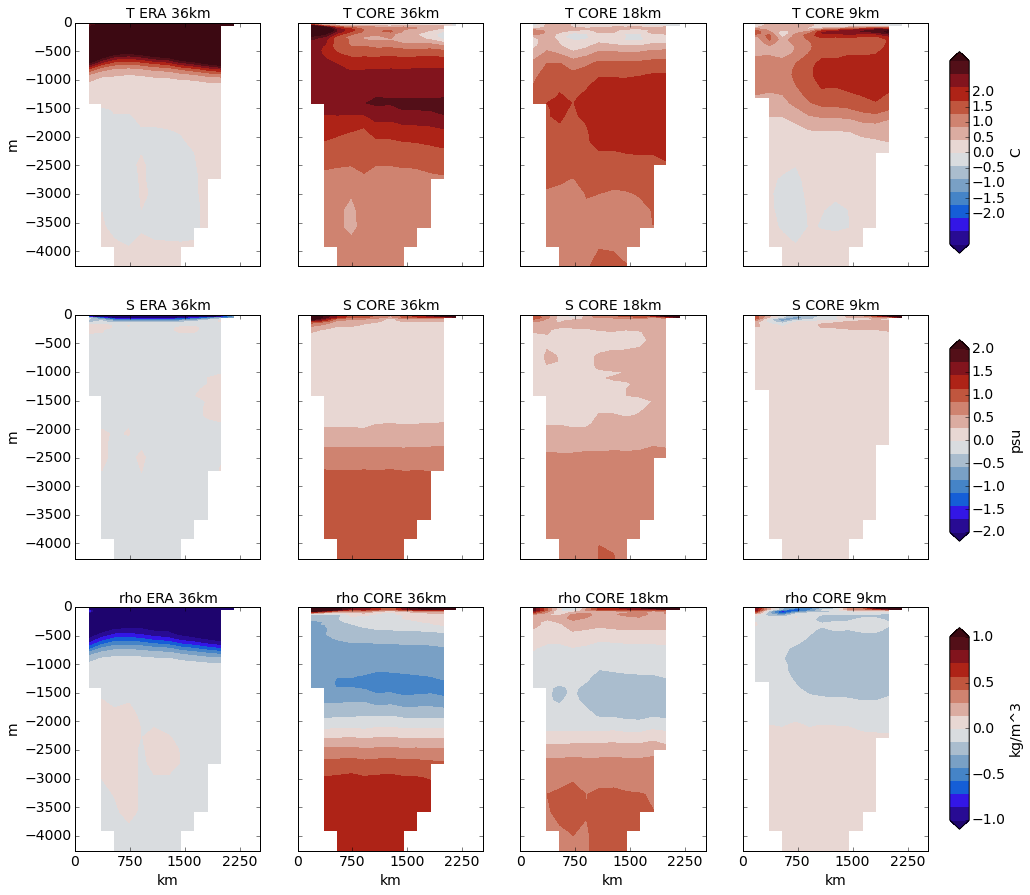

In [239]:
comp_diff_plot(comp_diff,woa,'arctic1')

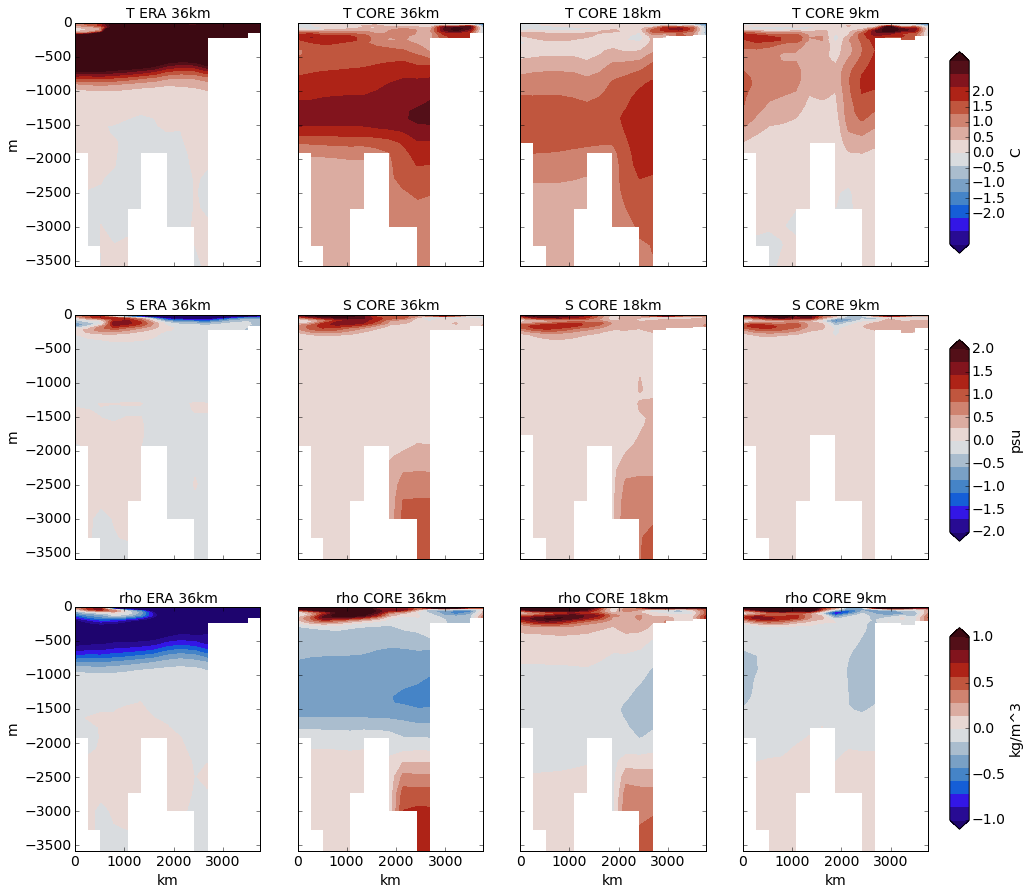

In [240]:
comp_diff_plot(comp_diff,woa,'arctic2')

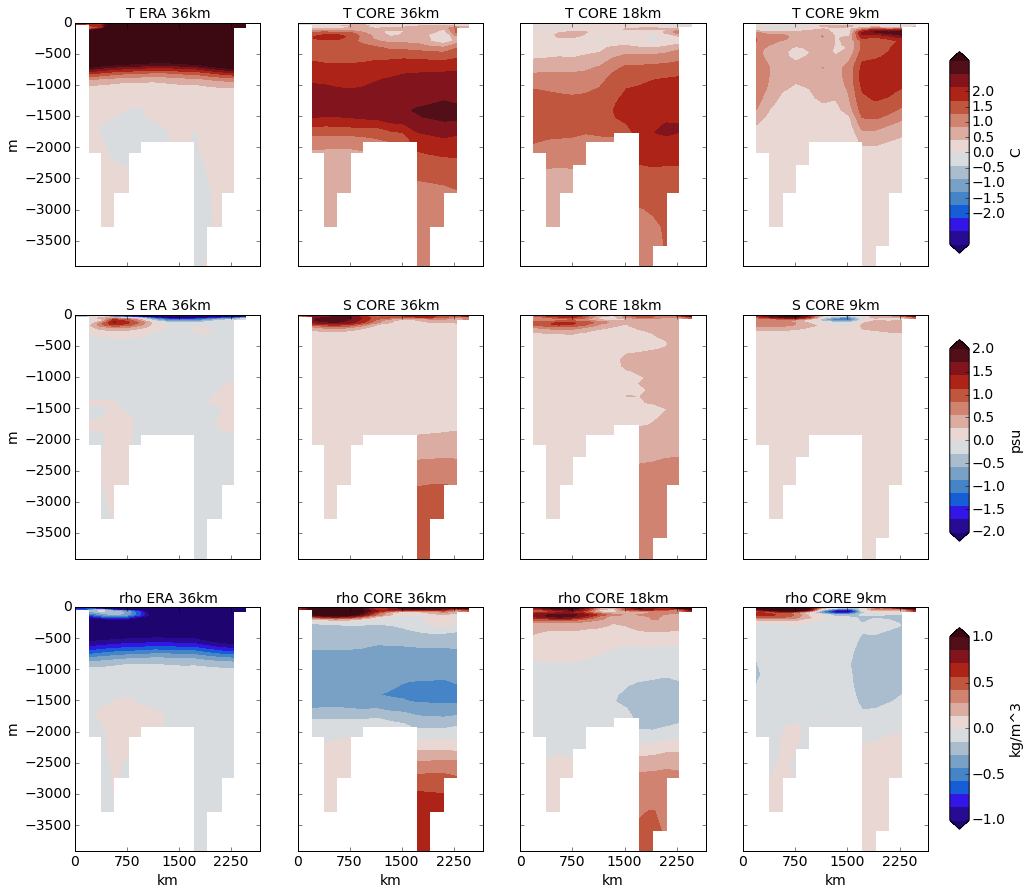

In [241]:
comp_diff_plot(comp_diff,woa,'arctic3')

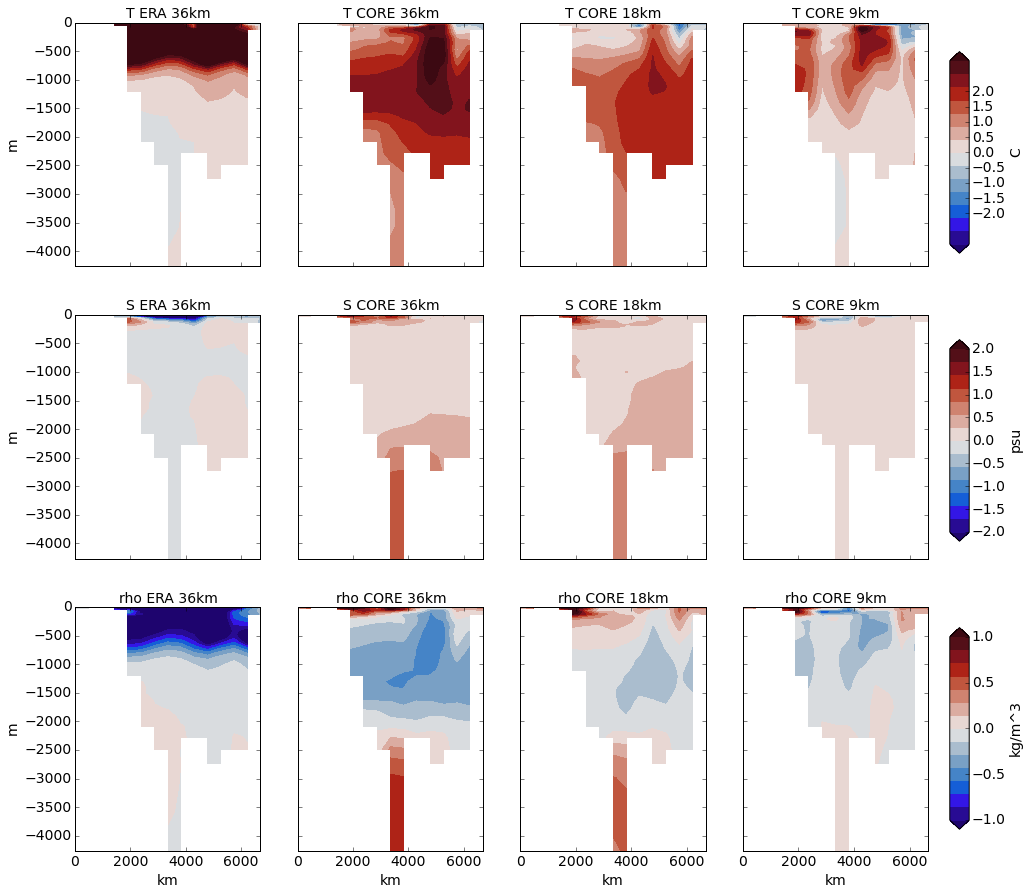

In [242]:
comp_diff_plot(comp_diff,woa,'arctic4')

In [ ]:
def plot_tot(comp,row=2,col=3):
    fig,axes = plt.subplots(row,col)
    vimin = -1
    vimax = 15
    ind = 0
    for ax in axes.flat:
        ax.set_title(comp[ind].title+' SST')
        masked_array = np.ma.array(comp[ind].T[0,:,:], mask=np.isnan(comp[ind].T[0,:,:]))
        cmap= cmocean.cm.temperature
        cmap.set_bad('grey',1.)
        ca = ax.imshow(masked_array,vmin = vimin, vmax = vimax, interpolation='nearest',cmap = cmap ,origin="lower")
        cbar = fig.colorbar(ca,ax=ax )
        ind +=1
        fig.subplots_adjust(right=2.7,top=2.6)
plot_tot(comp_pm)

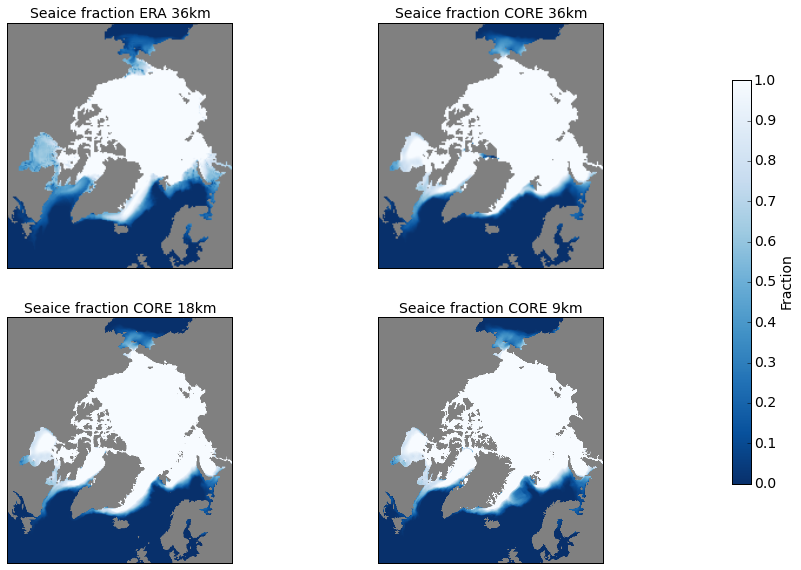

In [364]:
def plot_seaice(data_comp):
    vmin = 0
    vmax = 1
    tempbounds = range(vmin,vmax,2)
    cmap = matplotlib.cm.Blues_r
    cs = plt.imshow(data_comp[1].seaice['SIheff'][0,0,:,:],vmin=vmin,vmax=vmax,cmap=cmap)
    plt.colorbar(cs)
    plt.close()
    ind = 0 
    
    fig, axes = plt.subplots(2,2)
    for data in data_comp:
        masked_array = np.ma.array(np.nanmean(data_comp[data].seaice['SIheff'][:,0,:,:],axis=0),\
                                   mask=np.isnan(np.nanmean(data_comp[data].seaice['SIheff'][:,0,:,:],axis=0)))
        masked_array = np.fliplr(masked_array.T)
        cmap.set_bad('grey',1.)
        axes.flat[ind].imshow(masked_array,cmap=cmap,vmin=vmin, vmax=vmax,origin="left")
        axes.flat[ind].set_title('Seaice fraction '+data_comp[data].title)
        axes.flat[ind].title.set_fontsize('14')
        axes.flat[ind].tick_params(axis=u'both', which='both', bottom='off', top='off', right='off',
            left='off', labelbottom='off',labelleft='off') 
        ind += 1
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(cs, cax=cbar_ax,)
    cbar.ax.set_ylabel('Fraction')
# labels along the bottom edge are off

    fig.subplots_adjust(right=1.7,top=2.)
plot_seaice(comp_diff)


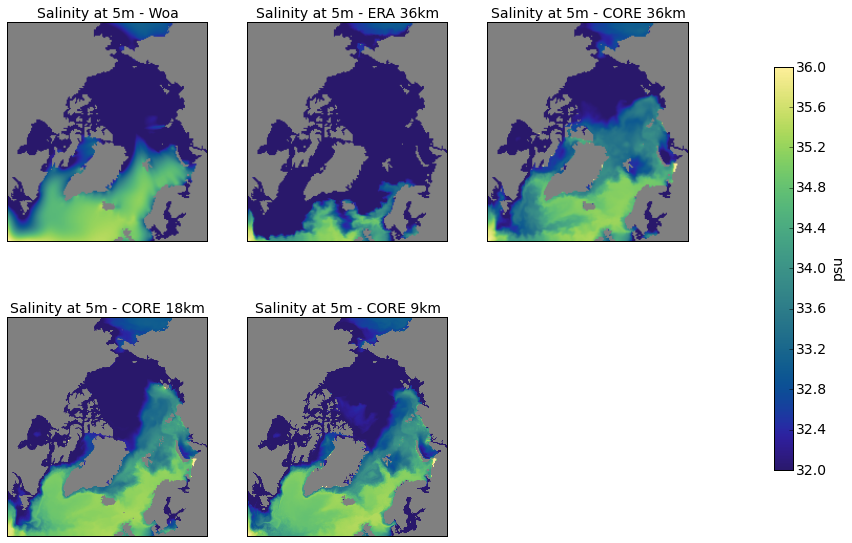

In [406]:
def plot_salinity(data_comp,m):
    vmin = 32
    vmax = 36
    if m == 5:
        mm = 0
    elif m == 200:
        mm = 16
    elif m == 400:
        mm = 21
    else:
        print "error: wrong depth level"
        
    cmap = cmocean.cm.salinity
    cs = plt.imshow(data_comp[1].S[mm,:,:],vmin=vmin,vmax=vmax,cmap=cmap)
    plt.colorbar(cs)
    plt.close()
    ind = 0 
    
    fig, axes = plt.subplots(2,3)
    for data in data_comp:
        masked_array = np.ma.array(data_comp[data].S[mm,:,:],mask=np.isnan(data_comp[data].S[mm,:,:]))
        masked_array = np.fliplr(masked_array.T)
        cmap.set_bad('grey',1.)
        axes.flat[ind].imshow(masked_array,cmap=cmap,vmin=vmin, vmax=vmax,origin="left")
        axes.flat[ind].set_title('Salinity at '+str(m)+'m - '+data_comp[data].title)
        axes.flat[ind].title.set_fontsize('14')
        axes.flat[ind].tick_params(axis=u'both', which='both', bottom='off', top='off', right='off',
            left='off', labelbottom='off',labelleft='off') 
        ind += 1
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(cs, cax=cbar_ax,)
    cbar.ax.set_ylabel('psu')
    fig.delaxes(axes.flat[-1])
    fig.subplots_adjust(right=1.7,top=2.)
    
plot_salinity(comp_all,5)
#plot_salinity(comp_diff,200)
#plot_salinity(comp_diff,400)

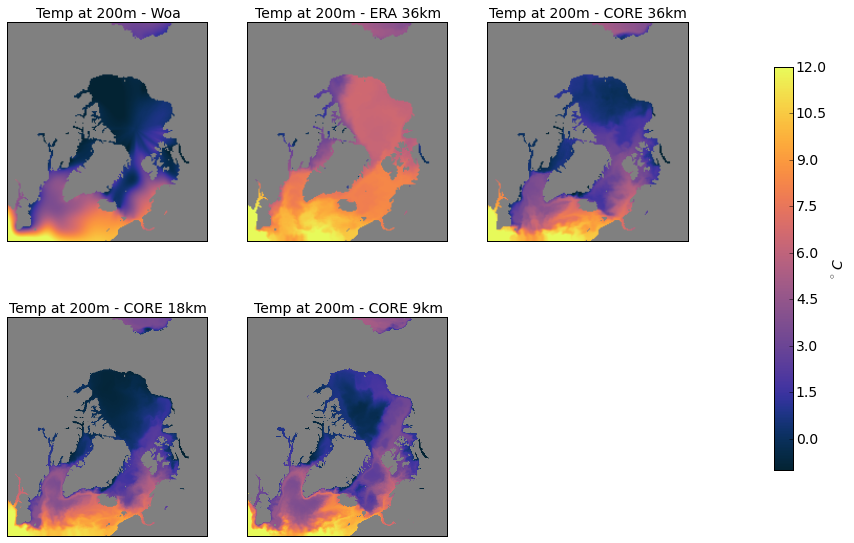

In [405]:
def plot_temperature(data_comp,m):
    vmin = -1
    vmax = 12
    if m == 5:
        mm = 0
    elif m == 200:
        mm = 16
    elif m == 400:
        mm = 21
    else:
        print "error: wrong depth level"
        
    cmap = cmocean.cm.temperature
    cs = plt.imshow(data_comp[1].T[mm,:,:],vmin=vmin,vmax=vmax,cmap=cmap)
    plt.colorbar(cs)
    plt.close()
    ind = 0 
    
    fig, axes = plt.subplots(2,3)
    for data in data_comp:
        masked_array = np.ma.array(data_comp[data].T[mm,:,:],mask=np.isnan(data_comp[data].T[mm,:,:]))
        masked_array = np.fliplr(masked_array.T)
        cmap.set_bad('grey',1.)
        axes.flat[ind].imshow(masked_array,cmap=cmap,vmin=vmin, vmax=vmax,origin="left")
        axes.flat[ind].set_title('Temp at '+str(m)+'m - '+data_comp[data].title)
        axes.flat[ind].title.set_fontsize('14')
        axes.flat[ind].tick_params(axis=u'both', which='both', bottom='off', top='off', right='off',
            left='off', labelbottom='off',labelleft='off') 
        ind += 1
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(cs, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$^{\circ}C$')
    fig.delaxes(axes.flat[-1])
    fig.subplots_adjust(right=1.7,top=2.)
    
plot_temperature(comp_all,200)